# 1) Importations

In [1]:
%pylab inline
import pandas as pd
import os
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression

Populating the interactive namespace from numpy and matplotlib


In [2]:
def display_progress_bar(n_tot, n_prog) :
    """
    A snippet of code to dispmay a progress bar for long operations
    """
    from time import sleep
    progress = math.ceil((n_prog + 1) * 100 / n_tot)
    sys.stdout.write('\r')
    sys.stdout.write("[%-100s] %d%%" %('='*progress, progress))
    sys.stdout.flush()
    sleep(0.25)

# 2) Data loading

In [3]:
# Getting current path
path = os.getcwd()

# Verifying data presence
try :
    data_raw = pd.read_csv(path + "/data/movie_metadata.csv", sep=',')
except FileNotFoundError :
    print("Please check if the file 'movie_metadata.csv' is in the 'data' folder at the current location")

# 3) Data first observation

In [4]:
data_raw.shape

(5043, 28)

Not to big of a dataset, what's in it ?

In [5]:
data_raw.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


First four lines are whole, the fifth is very incomplete/gappy

Closer look to each feature

In [6]:
for feat in data_raw.columns :
    print("%s : -%a- " % (feat, data_raw.loc[0,feat]))

color : -'Color'- 
director_name : -'James Cameron'- 
num_critic_for_reviews : -723.0- 
duration : -178.0- 
director_facebook_likes : -0.0- 
actor_3_facebook_likes : -855.0- 
actor_2_name : -'Joel David Moore'- 
actor_1_facebook_likes : -1000.0- 
gross : -760505847.0- 
genres : -'Action|Adventure|Fantasy|Sci-Fi'- 
actor_1_name : -'CCH Pounder'- 
movie_title : -'Avatar\xa0'- 
num_voted_users : -886204- 
cast_total_facebook_likes : -4834- 
actor_3_name : -'Wes Studi'- 
facenumber_in_poster : -0.0- 
plot_keywords : -'avatar|future|marine|native|paraplegic'- 
movie_imdb_link : -'http://www.imdb.com/title/tt0499549/?ref_=fn_tt_tt_1'- 
num_user_for_reviews : -3054.0- 
language : -'English'- 
country : -'USA'- 
content_rating : -'PG-13'- 
budget : -237000000.0- 
title_year : -2009.0- 
actor_2_facebook_likes : -936.0- 
imdb_score : -7.9- 
aspect_ratio : -1.78- 
movie_facebook_likes : -33000- 


Wait, what's this '\xa0' at the end of the movie's title ? Let's take some random samples

In [7]:
rands = np.random.randint(0,4000,5)
for rand_samp in rands :
    print("movie : -%s-" % data_raw.loc[rand_samp, "movie_title"])

movie : -Mystery, Alaska -
movie : -Eternal Sunshine of the Spotless Mind -
movie : -This Is It -
movie : -The Illusionist -
movie : -Dancer in the Dark -


Weird, there is a space at the end of the name though

In [8]:
data_raw.loc[rands[0], "movie_title"]

'Mystery, Alaska\xa0'

Alright, most-likely an encoding error, let's strip those

In [9]:
data_raw.loc[:, "movie_title"] = data_raw.loc[:, "movie_title"].apply(lambda x : x.strip())

Check :

In [10]:
data_raw.loc[rands[0], "movie_title"]

'Mystery, Alaska'

Completely empty columns ?

In [11]:
empty_col = data_raw.isnull().all(axis=0).sum()
print("There is %i empty columns in this dataset" % empty_col)

There is 0 empty columns in this dataset


Completely empty entries ?

In [12]:
empty_entry = data_raw.isnull().all(axis=1).sum()
print("There is %i empty entry in this dataset" % empty_entry)

There is 0 empty entry in this dataset


Good news

Obvious duplicates ?

In [13]:
data_raw[data_raw.duplicated()].shape

(45, 28)

Drop obvious duplicates if any

In [14]:
data_raw = data_raw.drop_duplicates(keep='first')
data_raw.shape

(4998, 28)

Movies duplicates ?

In [15]:
dup = data_raw[data_raw.duplicated(subset=["movie_title"])]
n_dup = dup.shape[0]
print("%i duplicates sharing movie title" % n_dup)

82 duplicates sharing movie title


Are some of those remakes ?

In [16]:
dups = data_raw[data_raw.duplicated(subset=["movie_title", "title_year"])]
n_dups = dups.shape[0]
print("%i duplicates sharing movie title and year, therefore %i potential remakes" % (n_dups, n_dup - n_dups))

79 duplicates sharing movie title and year, therefore 3 potential remakes


In [17]:
dup_all = data_raw[data_raw.duplicated(subset=["movie_title"], keep=False)]
# Grouping by title and year
grouped = dup_all.groupby(["movie_title", "title_year"])
# Looking for singletons : potential remakes
for name,group in grouped:
    if len(group.index) < 2 :
        print(name)

('Out of the Blue', 1980.0)
('Out of the Blue', 2006.0)
('The Dead Zone', 1983.0)
('The Host', 2006.0)
('The Host', 2013.0)


A quick online check indicates that those are not remakes, but completely different movies. We'll keep them

Remove the duplicates of movie title

In [18]:
data_raw = data_raw.drop_duplicates(subset=["movie_title", "title_year"], keep='first')
print(data_raw.shape)

(4919, 28)


Look at our features

In [19]:
labels = data_raw.columns
for lab in labels : print(lab)

color
director_name
num_critic_for_reviews
duration
director_facebook_likes
actor_3_facebook_likes
actor_2_name
actor_1_facebook_likes
gross
genres
actor_1_name
movie_title
num_voted_users
cast_total_facebook_likes
actor_3_name
facenumber_in_poster
plot_keywords
movie_imdb_link
num_user_for_reviews
language
country
content_rating
budget
title_year
actor_2_facebook_likes
imdb_score
aspect_ratio
movie_facebook_likes


# 4) Missing values

In [20]:
data_raw.isna().sum()

color                         19
director_name                102
num_critic_for_reviews        49
duration                      15
director_facebook_likes      102
actor_3_facebook_likes        23
actor_2_name                  13
actor_1_facebook_likes         7
gross                        863
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  23
facenumber_in_poster          13
plot_keywords                152
movie_imdb_link                0
num_user_for_reviews          21
language                      12
country                        5
content_rating               301
budget                       485
title_year                   106
actor_2_facebook_likes        13
imdb_score                     0
aspect_ratio                 326
movie_facebook_likes           0
dtype: int64

Some looks related(names and facebook likes for instance)

Remove features not of interest for our prediction tool

In [21]:
# Pop the facebook likes as it's complecated to link those to their owner in our data
data_raw = data_raw.drop(['director_facebook_likes'], axis=1)
data_raw = data_raw.drop(['cast_total_facebook_likes'], axis=1)
data_raw = data_raw.drop(['actor_1_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes'], axis=1)
# Drop the budget, which won't be on the same scale according to the time period or the country (currency)
data_raw = data_raw.drop(['budget'], axis=1)
# Dropping other features
data_raw = data_raw.drop(['aspect_ratio'], axis=1)
data_raw = data_raw.drop(['facenumber_in_poster'], axis=1)
# Dropping movie gross, as this is not a criteria for our recommendation tool (could be though)
data_raw = data_raw.drop(['gross'], axis=1)
# Content rating should more be used as a main filter, not as a recommendation parameter
data_raw = data_raw.drop(['content_rating'], axis=1)

New shape

In [22]:
data_raw.shape

(4919, 18)

In [23]:
data_raw.isna().sum()

color                      19
director_name             102
num_critic_for_reviews     49
duration                   15
actor_2_name               13
genres                      0
actor_1_name                7
movie_title                 0
num_voted_users             0
actor_3_name               23
plot_keywords             152
movie_imdb_link             0
num_user_for_reviews       21
language                   12
country                     5
title_year                106
imdb_score                  0
movie_facebook_likes        0
dtype: int64

We will tend to reduce the missing values to zero

In [24]:
def missing_values(df) :
    """
    Function for dealing with each column's missing values in an appropriate way
    Some errors are therefore induced to the database, but those are limited and 
    carefully taken into account
    """
    
    from sklearn.linear_model import LinearRegression
    from sklearn import preprocessing
    from scipy.optimize import curve_fit
    
    temp_df = df.copy()
    n_rows_init = df.shape[0]
    
    for label in df.columns :    
        
        if label == 'color' :
            print("Removing rows with color and title year missing")        
            # if the title year is missing as well as the color type : drop the row
            temp_df = temp_df.dropna(how='all', subset=[label, 'title_year'])
            
            print("Imputing missing color values according to title_year (<1970 : B&W)")   
            # if the year is >= 1970 : color, else B&W
            temp_df.loc[(temp_df[label].isna()) & (temp_df['title_year'] >= 1970), label] = "Color"
            temp_df.loc[(temp_df[label].isna()) & (temp_df['title_year'] < 1970), label] = "Black and White"
            
        elif label == 'director_name' :
            print("Removing rows with missing director's name")   
            # Remove those entries, sadly can't impute director's name
            temp_df = temp_df.dropna(subset=[label])
            
        elif label in['actor_1_name', 'actor_2_name', 'actor_3_name'] :
            print("Removing rows with missing actor's name")   
            # Remove those entries, sadly can't impute actor's name
            temp_df = temp_df.dropna(subset=[label])
            
        elif label == 'num_critic_for_reviews' :
            print("Imputing missing values of num_critic_for_reviews from linear regression with movie_facebook_likes")   
            # R2 score of 0.61
            
            clean_temp_df = df.dropna()
            # Implementing linear regression
            x = clean_temp_df['movie_facebook_likes'].values
            y = clean_temp_df[label].values
            x = x.reshape(len(x), 1)
            y = y.reshape(len(x), 1)
            regr = LinearRegression()
            regr.fit(x, y)
            # Imputing values
            x_pred = temp_df.loc[temp_df[label].isna(), "movie_facebook_likes"].values
            x_pred = x_pred.reshape(len(x_pred), 1)
            temp_df.loc[temp_df[label].isna(), label] = regr.predict(x_pred)

        elif label == 'duration' :
            print("Replacing missing duration by average of durations")
            mean = temp_df[label].mean()
            temp_df.loc[temp_df[label].isna(), label] = mean

        elif label == 'gross' :
            print("Replacing missing gross values by average of gross values <= 5e8 $")
            mean = temp_df[label][temp_df[label] <= 5e8].mean()
            temp_df.loc[temp_df[label].isna(), label] = mean

        elif label == 'genres' :
            print("Removing rows with missing genres")   
            # Remove those entries, sadly can't impute genres of a movie
            temp_df = temp_df.dropna(subset=[label])

        elif label == 'movie_title' :
            print("Removing rows with missing movie_title")   
            # Remove those entries, sadly can't impute movie_title
            temp_df = temp_df.dropna(subset=[label])

        elif label == 'num_voted_users' :
            print("Replacing missing num_voted_users by average of num_voted_users")
            # Not mandatory here, but might need another look if new entries in the database
            mean = temp_df[label].mean()
            temp_df.loc[temp_df[label].isna(), label] = mean

        elif label == 'num_user_for_reviews' :
            print("Imputing missing values of num_user_for_reviews from linear regression with num_voted_users")   
            # R2 score of 0.60
            
            clean_temp_df = df.dropna()
            # Implementing linear regression
            x = clean_temp_df['num_voted_users'].values
            y = clean_temp_df[label].values
            x = x.reshape(len(x), 1)
            y = y.reshape(len(x), 1)
            regr = LinearRegression()
            regr.fit(x, y)
            # Imputing values
            x_pred = temp_df.loc[temp_df[label].isna(), "num_voted_users"].values
            x_pred = x_pred.reshape(len(x_pred), 1)
            temp_df.loc[temp_df[label].isna(), label] = regr.predict(x_pred)

        elif label == 'language' :
            print("Removing rows with language and country missing")        
            # if the language is missing as well as the country : drop the row
            temp_df = temp_df.dropna(how='all', subset=[label, 'country'])
            
            print("Imputing missing language values according to country (english only)")   
            # if the year is >= 1970 : color, else B&W
            eng_countries = ["UK", "USA", "Ireland", "New Zealand", "Australia", "Canada"]
            temp_df.loc[(temp_df[label].isna()) & (temp_df['country'].isin(eng_countries)), label] = "English"
            
            print("Removing remaining rows with language missing") 
            temp_df = temp_df.dropna(subset=[label])

        elif label == 'plot_keywords' :
            print("Removing rows with missing plot_keywords")   
            # Remove those entries, sadly can't impute plot_keywords
            temp_df = temp_df.dropna(subset=[label])
            
        elif label == 'country' :
            print("Removing rows with missing country")   
            # Remove those entries, sadly can't impute country
            temp_df = temp_df.dropna(subset=[label])
            
        elif label == 'title_year' :
            print("Imputing missing values of title_year from logarithmic regression with movie_imdb_link")   
            # R2 score of 0.85
            # Spearman of 0.98
            
            link_df = temp_df.loc[:, ['movie_imdb_link']]
            
            train_year_df = temp_df.dropna().loc[:, ['title_year']]
            train_link_df = temp_df.dropna().loc[:, ['movie_imdb_link']]
            
            # Encoding categorial column
            le = preprocessing.LabelEncoder()
            le = le.fit(link_df.values.reshape(-1))
            temp_df_encoded = link_df.apply(le.transform)
            
            x = train_link_df.apply(le.transform).values
            y = train_year_df.values

            data = np.column_stack([x, y])
            data = data[data[:,0].argsort()]
            x_data = data[:,0].transpose()
            y_data = data[:,1].transpose()
            
            # define a function for fitting
            def func(x, a, b, c, d):
                return a * np.exp(-b * (x - c)) + d

            # fit data and get fit parameters
            popt, pcov = curve_fit(func, x_data, y_data)

            # Imputing values
            x_pred = temp_df_encoded.loc[temp_df[label].isna(), "movie_imdb_link"].values
            x_pred = x_pred.reshape(len(x_pred), 1)
            temp_df.loc[temp_df[label].isna(), label] = func(x_pred, *popt)

        elif label == 'imdb_score' :
            print("Replacing missing imdb_score by average of imdb_score")
            # Not mandatory here, but might need another look if new entries in the database
            mean = temp_df[label].mean()
            temp_df.loc[temp_df[label].isna(), label] = mean
            
    n_rows_end = temp_df.shape[0]
    rows_deleted = n_rows_init - n_rows_end
    print("%i rows have been deleted over %i" % (rows_deleted, n_rows_init))
    
    return temp_df

In [25]:
# Run missing values function
data_no_mv = data_raw.copy()
data_no_mv = missing_values(data_no_mv)

Removing rows with color and title year missing
Imputing missing color values according to title_year (<1970 : B&W)
Removing rows with missing director's name
Imputing missing values of num_critic_for_reviews from linear regression with movie_facebook_likes
Replacing missing duration by average of durations
Removing rows with missing actor's name
Removing rows with missing genres
Removing rows with missing actor's name
Removing rows with missing movie_title
Replacing missing num_voted_users by average of num_voted_users
Removing rows with missing actor's name
Removing rows with missing plot_keywords
Imputing missing values of num_user_for_reviews from linear regression with num_voted_users
Removing rows with language and country missing
Imputing missing language values according to country (english only)
Removing remaining rows with language missing
Removing rows with missing country
Imputing missing values of title_year from logarithmic regression with movie_imdb_link
Replacing missin

C:\Users\simon\Anaconda3\lib\site-packages\ipykernel_launcher.py:145: RuntimeWarning: overflow encountered in multiply


All of this for 260 values, still : no missing values at the end

In [26]:
data_no_mv.isna().sum()

color                     0
director_name             0
num_critic_for_reviews    0
duration                  0
actor_2_name              0
genres                    0
actor_1_name              0
movie_title               0
num_voted_users           0
actor_3_name              0
plot_keywords             0
movie_imdb_link           0
num_user_for_reviews      0
language                  0
country                   0
title_year                0
imdb_score                0
movie_facebook_likes      0
dtype: int64

In [27]:
# Now we can drop the 'movie_imdb_link' feature
data_no_mv = data_no_mv.drop(['movie_imdb_link'], axis=1)

# 5) Outliers

Let's see if some outliers step out of the crowd

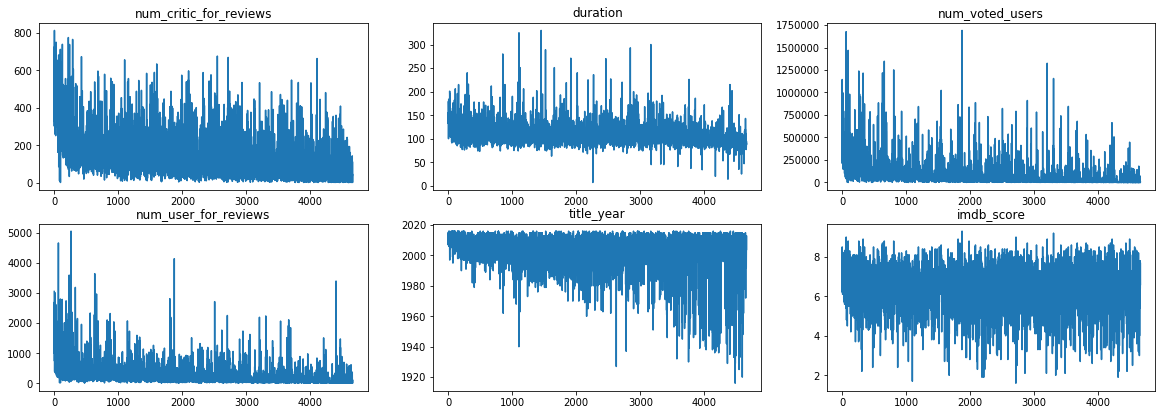

In [28]:
#plot by label
fig = plt.figure(figsize=(20,40))
num_df = data_no_mv.select_dtypes(['float64', 'int64'])
for label, num in zip(num_df.columns, range(1,len(num_df.columns))) :    
    data = data_no_mv[label].values    
    ax = fig.add_subplot(11,3,num)
    ax.plot(data)
    ax.set_title(label)

Not so much : no treatment necessary

# 6) More Feature Engineering

Remove the space in front of " Black and White"

In [29]:
data_no_mv['color'] = data_no_mv['color'].str.strip()

Reindex dataframe

In [30]:
data_no_mv = data_no_mv.reset_index(drop=True)

Feature engineering for genres : let's do some OneHot encoding manually. We expect one feature by genre

In [31]:
# Get splitted genres in a serie
s = data_no_mv.genres.str.split("|").values.tolist()
# Get unique genres
unique_genres = [genres_out for genres_in in s for genres_out in genres_in]
unique_genres = set(unique_genres)
unique_genres = list(unique_genres)
print("%i genres in the dataset" % len(unique_genres))

24 genres in the dataset


In [32]:
# Initialize the genres df
genres_df = pd.DataFrame(columns=unique_genres)

In [33]:
def assign_genres(row, genre_column) :
    """
    Short routine to populate the rows of the genre DF
    """
    genre_found = 0
    string_genres = row.loc['genres']
    genres_list = string_genres.split("|")
    if genre_column in genres_list :
        genre_found = 1
    return genre_found

In [34]:
# Assign genres to entries
count = 0
for genre in unique_genres :
    genres_df.loc[:, genre] = data_no_mv.apply(assign_genres, axis=1, args=(genre,))
    display_progress_bar(len(unique_genres), count)
    count += 1

[====================================================================================================] 100%

Well, have a look at our new genre df

In [35]:
genres_df.head()

,Family,Action,Animation,Western,Romance,Sport,Adventure,Comedy,War,Drama,...,History,Horror,Documentary,News,Music,Sci-Fi,Film-Noir,Thriller,Crime,Biography
0,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


Sounds about right, let's check with our 5 first movies

In [36]:
data_no_mv.loc[:,"genres"].head()

0    Action|Adventure|Fantasy|Sci-Fi
1           Action|Adventure|Fantasy
2          Action|Adventure|Thriller
3                    Action|Thriller
4            Action|Adventure|Sci-Fi
Name: genres, dtype: object

Feature engineering for keywords : let's do some OneHot encoding manually. We expect one feature by keyword

In [37]:
# Get splitted keywords in a serie
s = data_no_mv.plot_keywords.str.split("|").values.tolist()
# Get unique keywords
keywords = [keywords_out for keywords_in in s for keywords_out in keywords_in]
unique_keywords = set(keywords)
unique_keywords = list(unique_keywords)
print("%i keywords in the dataset" % len(unique_keywords))

7963 keywords in the dataset


In [38]:
# Get unique kw and counts
kw_arr = np.array(keywords)
kw_unique, kw_count = np.unique(kw_arr, return_counts=True)
# Sort by count
kw_id_sort = np.argsort(-kw_count)
# Get kw sorted by counts
kw_unique_sorted = kw_unique[kw_id_sort]
# First 10 kw
kw_unique_sorted[:10]

array(['love', 'friend', 'murder', 'death', 'police', 'new york city',
       'high school', 'alien', 'boy', 'school'], dtype='<U102')

We'll use the first 100 keywords sorted by counts to avoid too many features

In [39]:
# Initialize the keywords dataframe
n_first_kw = 100
kw_df = pd.DataFrame(columns=kw_unique_sorted[:n_first_kw])

In [40]:
def assign_kw(row, kw_column) :
    """
    Short routine to populate the rows of the genre DF
    """
    kw_found = 0
    string_kw = row.loc['plot_keywords']
    kw_list = string_kw.split("|")
    if kw_column in kw_list :
        kw_found = 1
    return kw_found

In [41]:
# Assign most common 100 keywords to entries
count = 0
for kw in kw_unique_sorted[:n_first_kw] :
    kw_df.loc[:, kw] = data_no_mv.apply(assign_kw, axis=1, args=(kw,))
    display_progress_bar(len(kw_unique_sorted[:n_first_kw]), count)
    count += 1

[====================================================================================================] 100%

Have a look

In [42]:
kw_df.head()

,love,friend,murder,death,police,new york city,high school,alien,boy,school,...,african american,gang,family relationships,monster,martial arts,priest,nudity,military,russian,based on true story
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Feature engineering for actors : let's do some OneHot encoding manually. We expect one feature by actor's name

In [69]:
# DF of lists for treatment, string for unique actors
actors_df_init = pd.DataFrame()
actors_df_init['actors'] = data_no_mv.loc[:,'actor_1_name'] + "|" + data_no_mv.loc[:,'actor_2_name'] + "|" + data_no_mv.loc[:,'actor_3_name']
actors_features = ['actor_1_name', 'actor_2_name', 'actor_3_name']
actors_df_init_lists = pd.DataFrame()
actors_df_init_lists['actors'] = data_no_mv.loc[:,actors_features].apply(lambda x: list(x), axis=1)

In [70]:
# Get splitted actors in a serie
s = actors_df_init.actors.str.split("|").values.tolist()
# Get unique actors
unique_actors = [actors_out for actors_in in s for actors_out in actors_in]
unique_actors = set(unique_actors)
unique_actors = list(unique_actors)
print("%i actors in the dataset" % len(unique_actors))

5841 actors in the dataset


In [84]:
# Assign actors to entries (very, very long)
# Verifying data presence
try :
    actors_df = pd.read_csv(path + "/data/actors_df.csv", sep=',')
except FileNotFoundError :
    actors_df = pd.DataFrame(columns=unique_actors)
    count = 0
    for actor in unique_actors :
        actors_df.loc[:, actor] = actors_df_init_lists.apply(lambda row : 1 if actor in row.values[0] else 0, axis=1)
        display_progress_bar(len(unique_actors), count)
        count += 1
    # Save actors df (long to compute) for next time
    actors_df.to_csv("data/actors_df.csv", index=False)

In [85]:
actors_df.head()

,Nelson Ascencio,Kelly Rowan,Julianna Guill,Adrian Paul,Corbin Allred,Tony Nappo,Amber Valletta,Eric Idle,Tim Daly,Ruth Sheen,...,Kelly Lynch,Rip Torn,Mackenzie Aladjem,Ella Wahlestedt,Jeff Garlin,Scott Adsit,Louise Fletcher,Rachel Crow,Hulk Hogan,Billy Brown
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Assemble different DataFrames, shapes ?

In [87]:
print("data : ", data_no_mv.shape)
print("actors : ", actors_df.shape)
print("genres : ", genres_df.shape)
print("keywords : ", kw_df.shape)

data :  (4659, 17)
actors :  (4659, 5841)
genres :  (4659, 24)
keywords :  (4659, 100)


In [88]:
# Pop main df features
data_new = data_no_mv.copy()
data_new = data_new.drop(['genres'], axis=1)
data_new = data_new.drop(['plot_keywords'], axis=1)
data_new = data_new.drop(actors_features, axis=1)

In [89]:
print("data : ", data_new.shape)
print("actors : ", actors_df.shape)
print("genres : ", genres_df.shape)
print("keywords : ", kw_df.shape)

data :  (4659, 12)
actors :  (4659, 5841)
genres :  (4659, 24)
keywords :  (4659, 100)


In [90]:
# Concatenate main df and genres df
data_new = pd.concat([data_new, genres_df], axis=1)
print("data new : ", data_new.shape)
# Concatenate main df and plot_keywords df
data_new = pd.concat([data_new, kw_df], axis=1)
print("data new : ", data_new.shape)
# Concatenate main df and actors df
data_new = pd.concat([data_new, actors_df], axis=1)
print("data new : ", data_new.shape)

data new :  (4659, 36)
data new :  (4659, 136)
data new :  (4659, 5977)


Have a look at our data

In [91]:
data_new.columns.values[:25]

array(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'movie_title', 'num_voted_users', 'num_user_for_reviews',
       'language', 'country', 'title_year', 'imdb_score',
       'movie_facebook_likes', 'Family', 'Action', 'Animation', 'Western',
       'Romance', 'Sport', 'Adventure', 'Comedy', 'War', 'Drama',
       'Mystery', 'Short', 'Fantasy'], dtype=object)

Save reduced data for exploration

In [92]:
print(data_new.shape)
data_new.to_csv("data/movie_recommendation_reduced_data.csv", index=False)

(4659, 5977)


Save reduced data for deployment

In [93]:
data_new.to_csv("data/movie_recommendation_tool_data.csv")